Написати програму, яка навчає та тестує модель, що виконує задачу
бінарної класифікації відповідно до варіанту, оцінити модель за допомогою
відповідних метрик та спробувати її покращити.

Варіант 6: blood.csv. Класифікувати донорів крові за двома типами (останній
стовпець), використовуючи будь-які незалежні змінні.

In [4]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module=r"imblearn\.ensemble\._forest"
)


In [6]:
import pandas as pd
import numpy as np

# 1. Load data
data = pd.read_csv('blood.csv')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


Бачимо що датасет має 748 спостережень (рядків) і 5 змінних (стовпців) типу int64. Також у жодному стовпці немає пропущених значень.
Це означає, що на рівні базового огляду датасет вже «чистий» (немає пропусків), усі ознаки числові й готові до побудови моделей.

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,748.0,9.506684,8.095396,0.0,2.75,7.0,14.0,74.0
Frequency,748.0,5.514706,5.839307,1.0,2.00,4.0,7.0,50.0
Monetary,748.0,1378.676471,1459.826781,250.0,500.00,1000.0,1750.0,12500.0
Time,748.0,34.282086,24.376714,2.0,16.00,28.0,50.0,98.0
Class,748.0,0.237968,0.426124,0.0,0.00,0.0,0.0,1.0


Можна зробити декілька висновків:
1. Бачимо асиметричний розподіл, бо значення Recency, Frequency та Monetary мають медіану (50%) значно меньшу за максимум (max) і разом з тим середнє (mean) трохи вище за медіану.
    Наприклад, Frequency медіана = 4.0, а максимум = 50.0, при тому що середнє = 5.5.
   Це означає що меншість донорів зі спостережень значно більш активна, оскілки саме меньшість даних має екстремальні значення.
   Але ці дані не варто видаляти чи оброблювати, бо вони не є "шумом" та важливі для визначення моделлю позитивних прикладів.

   На графіках нище відобразимо графік "ящик з вусами" (boxplot) для кожної з основних ознак (Recency, Frequency, Monetary) по класах (Class = 0 або 1).
   Якщо значення Recency будут більше зліва, це означатиме що "неактивні" донори давніше здавали кров. Для Frequency та Monetary навпаки - частіше здавали і більше крові здали, тобто "активні".

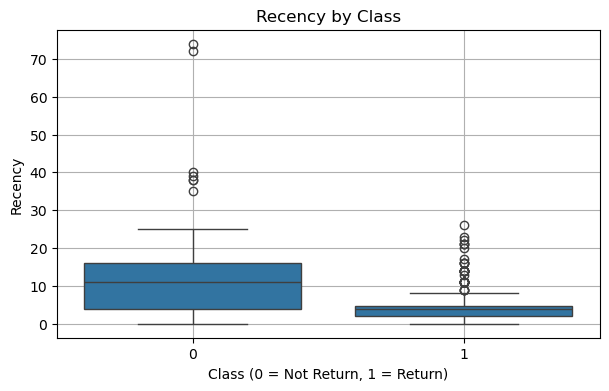

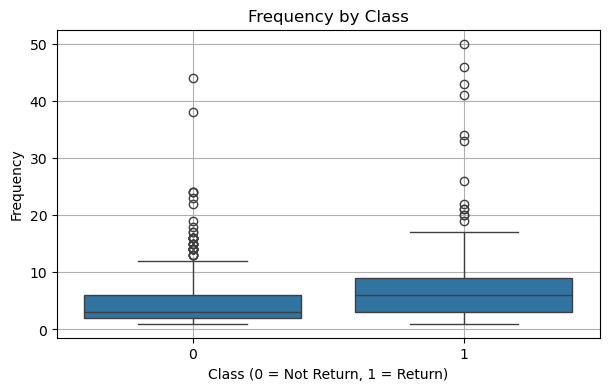

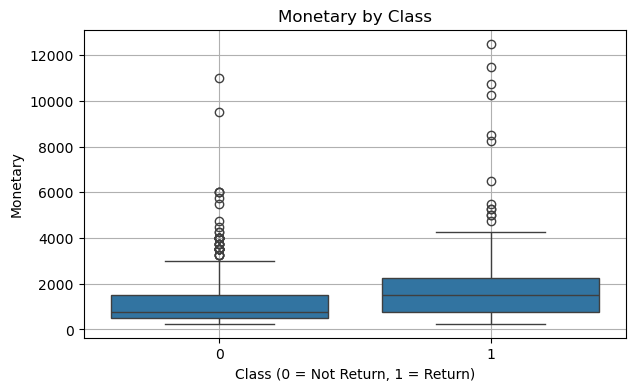

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Recency', 'Frequency', 'Monetary']

for feature in features:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x='Class', y=feature, data=data)
    plt.title(f'{feature} by Class')
    plt.xlabel('Class (0 = Not Return, 1 = Return)')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


2. Маємо приклад незбалансованих даних: Class - бінарна змінна, де середнє (mean) = 0.237968, тобто 24% усіх значень дорінює 1, а це приблизно 1/4 усії значень.
 Це може викликати складнощі при класифікації, наприклад модель може почати "лінитися" та завжди передбачати значення 0 (бо тоді значення accuracy вже буде дорівнювати 76%), тому тут потрібно використовувати не accuracy, а F1, ROC-AUC, precision/recall метрики.


=== Class distribution ===
Class 0: 570  (76.20 %)
Class 1: 178  (23.80 %)


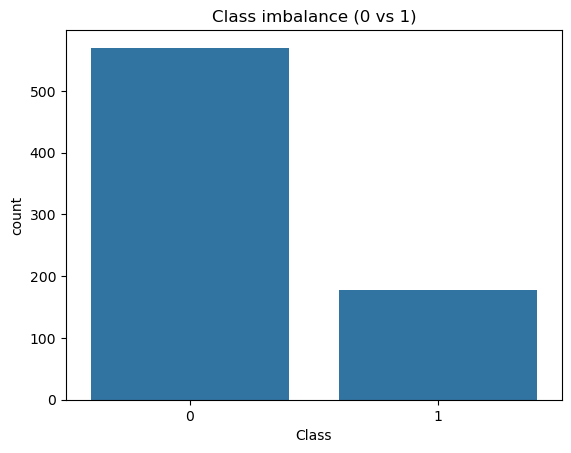

In [18]:
class_counts = data["Class"].value_counts().sort_index()
class_pct    = class_counts / class_counts.sum() * 100

print("\n=== Class distribution ===")
for c, n, p in zip(class_counts.index, class_counts, class_pct):
    print(f"Class {c}: {n}  ({p:.2f} %)")

sns.countplot(x="Class", data=data)
plt.title("Class imbalance (0 vs 1)")
plt.show()

На boxplot вище помітно що графіки Frequency та Monetary виглядають майже однаковими. Це скоріше за все означає пряму кореляцію між ними. 

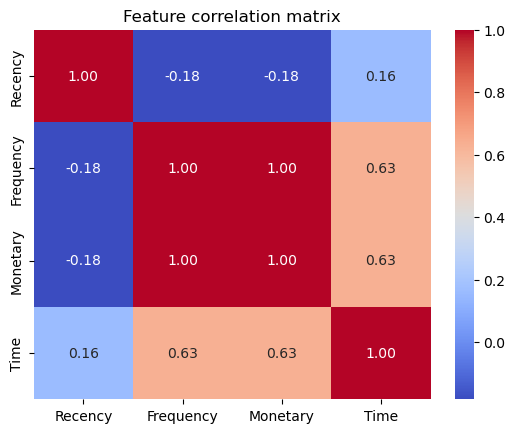

In [21]:
feat_corr = data.drop(columns="Class").corr()

sns.heatmap(feat_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature correlation matrix")
plt.show()

Кореляція дійсно є, вирахуємо нахил лінійної регресії.

In [24]:
x = data['Frequency'].values
y = data['Monetary'].values

slope, intercept = np.polyfit(x, y, 1)
print(f"Slope (polyfit) = {slope:.1f}")

Slope (polyfit) = 250.0


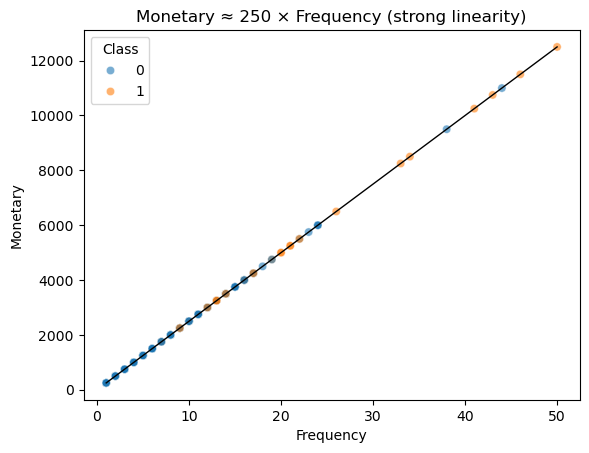

Pearson r(Frequency, Monetary) = 1.000


In [26]:
sns.scatterplot(data=data, x="Frequency", y="Monetary", hue="Class", alpha=0.6)
sns.regplot(data=data, x="Frequency", y="Monetary",
            scatter=False, color="black", line_kws={"lw":1})
plt.title("Monetary ≈ 250 × Frequency (strong linearity)")
plt.show()

corr_freq_mon = data[["Frequency", "Monetary"]].corr().iloc[0,1]
print(f"Pearson r(Frequency, Monetary) = {corr_freq_mon:.3f}")

Коефіціент кореляції Пірсона дорівнює 1 (що підтверджує матриця кореляції). 

Використання обох показників Frequency та Monetary не дасть додаткової вигоди.

Інженерія ознаки - створимо новий стовбчик.

In [29]:
df = data.copy()
df['donations_per_time'] = data['Frequency'] / data['Time']

print(df.head())

   Recency  Frequency  Monetary  Time  Class  donations_per_time
0        2         50     12500    98      1            0.510204
1        0         13      3250    28      1            0.464286
2        1         16      4000    35      1            0.457143
3        2         20      5000    45      1            0.444444
4        1         24      6000    77      0            0.311688


Далі перевіримо варіативність даних.

In [32]:
variance = df.var()
print("\n=== Feature variance ===")
print(variance)


=== Feature variance ===
Recency               6.553543e+01
Frequency             3.409751e+01
Monetary              2.131094e+06
Time                  5.942242e+02
Class                 1.815819e-01
donations_per_time    2.263911e-02
dtype: float64


Немає ознак з "майже нульовою" дисперсією, всі 4 мають достатній розкид (Class - це не ознака, а мітка).  

Виберемо чотири ознаки - Recency, Frequency, Time і donations_per_time - та цільову змінну Class, скопіюємо їх у X і y, після чого розіб’ємо дані на тренувальний (80 %) і тестовий (20 %) набори зі стратифікацією за класами й фіксованим random_state для відтворюваності, і виведемо розміри отриманих підвибірок.

In [36]:
from sklearn.model_selection import train_test_split

feature_cols = [
    "Recency", "Frequency", "Time", "donations_per_time"
]
X = df[feature_cols].copy()
y = df["Class"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape},  Test size: {X_test.shape}")

Train size: (598, 4),  Test size: (150, 4)


Налаштовуємо пайплайн зі StandardScaler (щоб привести всі ознаки до спільної шкали й забезпечити коректну роботу регуляризації) та LogisticRegression з class_weight='balanced' (щоб компенсувати дисбаланс класів і не допустити зсуву моделі в бік більшого класу), навчаємо модель на тренувальних даних, робимо прогноз для тестових і виводимо звіт із precision, recall та f1-score для обох класів.

In [39]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

blood_lr = ImbPipeline([
    ('scaler',   StandardScaler()),
    ('clf',      LogisticRegression(
                     solver='liblinear',
                     class_weight='balanced',
                     random_state=42))
])

blood_lr.fit(X_train, y_train)

y_pred_lr = blood_lr.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       114
           1       0.45      0.83      0.59        36

    accuracy                           0.72       150
   macro avg       0.69      0.76      0.69       150
weighted avg       0.81      0.72      0.74       150



Зазначимо що accuracy (відсоток правильно класифікованих значень) = 0.72. Це непоганий показник вцілому, але через наявність дісбалансу класів він не надійний. 
recall (процент релевантних значень з усіх що обрала модель, істинно позитивні / всі позитивні) - для 0 це 68%, для 1 - 83%.
precision (процент релевантних обраних значень з усіх що існують у виборці, істинно позитивні / релевантні елементи) - для 0 це 93%, для 1 - 45%
f1-score (показує баланс між влучністю (precision) та повнотою (recall)) - для 0 це 79%, для 1 - 59%.

Просте орієнтування тільки на влучність або повноту не є гарним рішенням для навчання моделі через те що дуже легко можна маніпулювати значенням одного показника за рахунок іншого. Тому в цій роботі зосередимося саме на значенні f1-score.  Вище значення цього показника допоможе мінімізувати кількість хибних резльтатів одночасно с мінімізацією пропуску істиних значень.

Для того щоб розрахувати достатній для нашої задачі показник f1-score враховуючи дісбаланс класів (24/76), спочатку зробимо "наївний" прогноз (при якому модель не використовує ніяких ознак, а просто постійно передбачає 0 (або 1), тобто baseline).

**Для позитивного класу (1):**

Precision = TP/TP+FP = 24/24+76 = 0,24
Recall = TP/TP+FN = 24/24+0 = 1

F1 = 2*(P*R)/(P+R) = 0,39

macro-F1 = (0,39+0)/2=0,195

**Для негативного класу (0):**

Precision = TP/TP+FP = 76/76+24 = 0,76
Recall = TP/TP+FN = 76/76+0 = 1

F1 = 2*(P*R)/(P+R) = 0,86

macro-F1 = (0+0,86)/2=0,43

Бачимо що для класу 1 f1 моделі більше показників baseline - 59% проти 39%.
Трошки зменьшився f1 для класу 0 (з 86% до 79%), але допустима "плата" за те що модель перестала ігнорувати випадки з 1.

Для даних з наявним дісбалансом можна спробувати використати метод SMOTE. 
Він розширює розмірність меньшої виборки шляхом інтерполяції існуючих даних.

In [44]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

smote_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42, k_neighbors=5)),
    ('clf',    LogisticRegression(solver='liblinear', random_state=42))
])

smote_lr.fit(X_train, y_train)
y_pred_smote = smote_lr.predict(X_test)


print("=== Logistic Regression + SMOTE ===")
print(classification_report(y_test, y_pred_smote))

=== Logistic Regression + SMOTE ===
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       114
           1       0.44      0.81      0.57        36

    accuracy                           0.71       150
   macro avg       0.68      0.74      0.67       150
weighted avg       0.80      0.71      0.73       150



Бачимо що на нашій вибирці це не покращило модель, а навпаки є невеличке падіння показників. У цього може бути декілька причин, але припустимо що це через невелику кількість позитивних вимірювань (142 в тренувальній вибирці). Можливо SMOTE створює забагато синтетичного шуму серед класу 1 і це погіршує результати.

Далі спробуємо використати BalancedRandomForestClassifier тому, що це ансамбль дерев, який всередині самостійно балансуватиме вибірку при побудові кожного дерева (undersampling більших класів), тож не потрібне зовнішнє масштабування ознак чи додаткове зважування—модель краще справляється з дисбалансом і автоматично шукає складні нелінійні взаємозв’язки.

In [48]:
from imblearn.ensemble import BalancedRandomForestClassifier

pipe_brf = ImbPipeline([
    ("clf",  BalancedRandomForestClassifier(
                 n_estimators=400,
                 max_depth=None,
                 random_state=42))
])

pipe_brf.fit(X_train, y_train)
y_pred_brf = pipe_brf.predict(X_test)

print("=== Balanced Random Forest ===")
print(classification_report(y_test, y_pred_brf))

=== Balanced Random Forest ===
              precision    recall  f1-score   support

           0       0.89      0.57      0.70       114
           1       0.36      0.78      0.50        36

    accuracy                           0.62       150
   macro avg       0.63      0.67      0.60       150
weighted avg       0.76      0.62      0.65       150



Також бачимо погіршення показників, тобто Balanced Random Forest працює гірше на нашій виборці даних.

Спробуємо CatBoost - бустинговий алгоритм добре працює з дисбалансними даними: він автоматично враховує нелінійні взаємозв’язки ознак, а параметр scale_pos_weight компенсує перевагу більшого класу, завдяки цьому модель не ігнорує рідкісні позитивні випадки і водночас не потребує зовнішнього балансування чи надмірного тюнінгу.

In [52]:
from catboost import CatBoostClassifier

scale_pos_w = y_train.value_counts()[0] / y_train.value_counts()[1]

pipe_cat = ImbPipeline([
    ("clf",  CatBoostClassifier(
                 iterations      = 1000,
                 depth           = 4,
                 learning_rate   = 0.05,
                 loss_function   = "Logloss",
                 scale_pos_weight= scale_pos_w,
                 verbose         = False,
                 random_state    = 42))
])

pipe_cat.fit(X_train, y_train)
y_pred_cat = pipe_cat.predict(X_test)

print("=== CatBoost ===")
print(classification_report(y_test, y_pred_cat))

=== CatBoost ===
              precision    recall  f1-score   support

           0       0.89      0.75      0.82       114
           1       0.47      0.69      0.56        36

    accuracy                           0.74       150
   macro avg       0.68      0.72      0.69       150
weighted avg       0.79      0.74      0.75       150



Зазначимо що CatBoost показує кращі показники f1 за попередню модель, але на тому ж рівні по macro avg з LogisticRegression.
Для більш детального аналізу, побудуємо Confusion Matrix для кожної з використаних моделей.

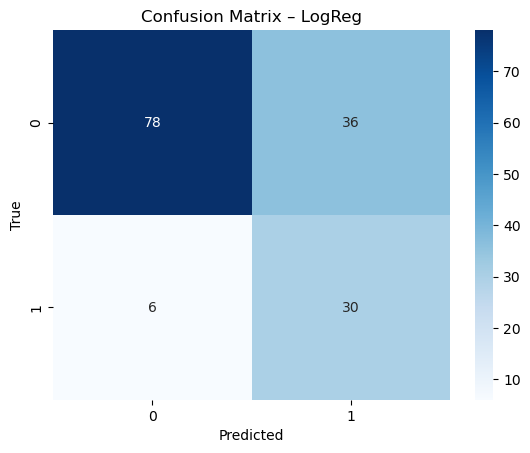

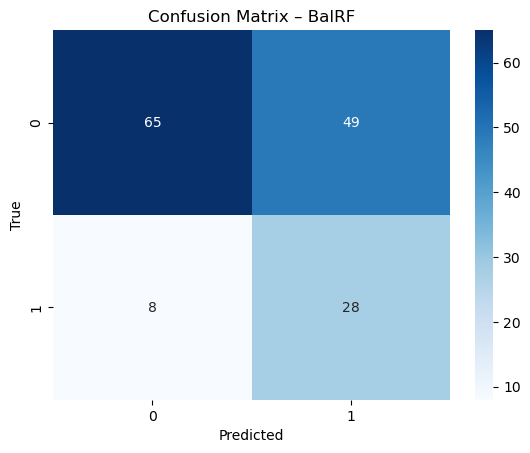

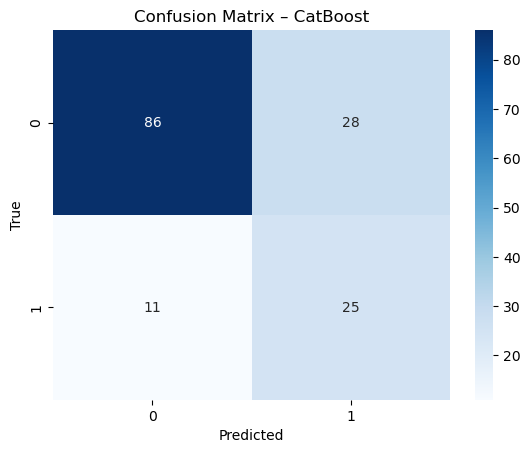

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

plot_cm(y_test, y_pred_lr,  "Confusion Matrix – LogReg")
plot_cm(y_test, y_pred_brf, "Confusion Matrix – BalRF")
plot_cm(y_test, y_pred_cat, "Confusion Matrix – CatBoost")


LogisticRegression - добре виявляє класи 0 та 1, майже не пропускає справжні 1 (виявляючи їх як 0), але все ж залишається велика кількість хибнопозитивних 1.

BalancedRandomForestClassifier - гірша за попередню модель. Меньше правильних передбачень як для 0 так і для 1 та найбільша кількість хибнопозитивних 1 серед усіх моделей.

CatBoost - теж непогані результати. Краще за LogisticRegression виявляє 0, але гірше 1. При тому вона має меньше хибнопозитивних результатів 1.

- якщо пріоритет - не втратити жодного позитивного випадку (мінімізувати FN), LogisticRegression;
- якщо важливіше звести до мінімуму хибні тривоги (FP), CatBoost;
- BalancedRF в цій вибірці доволі поступається обом.

Тепер спробуємо зробити єдиний конвейєр від підготовки до порівняння моделей: спершу застосувати StratifiedKFold з п’ятьма фолдами для збереження балансу класів, потім визначити три пайплайни (LogisticRegression, BalancedRandomForest, CatBoost) і для кожного задати власну сітку гіперпараметрів, далі через GridSearchCV з оцінкою за macro-F1 підібрати найкращі параметри, після чого на тестовій вибірці знайти оптимальний поріг для класифікації за макро-F1, зберегти звіти та на фінальному кроці автоматично обрати модель із найвищим macro-F1 на тесті.

In [80]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, classification_report, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "LogReg": {
        "pipeline": blood_lr,
        "params": [
            {
                'clf__solver': ['liblinear'],
                'clf__penalty': ['l1','l2'],
                'clf__C': np.logspace(-4,4,10),
                'clf__class_weight': ['balanced',{0:1,1:2},{0:1,1:3}],
                'clf__max_iter': [500,1000]
            },
            {
                'clf__solver': ['saga'],
                'clf__penalty': ['elasticnet'],
                'clf__C': np.logspace(-4,4,10),
                'clf__l1_ratio': [0,0.5,1.0],
                'clf__class_weight': ['balanced',{0:1,1:2}],
                'clf__max_iter': [500,1000]
            }
        ]
    },
    "BalancedRF": {
        "pipeline": pipe_brf,
        "params": {
            'clf__n_estimators': [100,200,400],
            'clf__max_depth': [None,10,20],
            'clf__max_features': ['sqrt','log2'],
            'clf__min_samples_leaf': [1,5,10]
        }
    },
    "CatBoost": {
        "pipeline": pipe_cat,
        "params": {
            'clf__iterations': [500,1000],
            'clf__depth': [4,6,8],
            'clf__learning_rate': [0.01,0.03,0.1],
            'clf__l2_leaf_reg': [1,3,5],
            'clf__bagging_temperature': [0,1,2]
        }
    }
}

results = []

for name, cfg in param_grids.items():
    print(f"\n>>> Tuning {name} ...")
    grid = GridSearchCV(
        estimator=cfg["pipeline"],
        param_grid=cfg["params"],
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        refit=True
    )
    grid.fit(X_train, y_train)
    
    y_prob = grid.predict_proba(X_test)[:,1]
    best_thr, best_f1 = 0.5, 0
    for thr in np.linspace(0,1,51):
        y_t = (y_prob >= thr).astype(int)
        f1m = f1_score(y_test, y_t, average='macro')
        if f1m > best_f1:
            best_f1, best_thr = f1m, thr
    
    y_opt = (y_prob >= best_thr).astype(int)
    report = classification_report(y_test, y_opt)
    
    results.append({
        "name": name,
        "best_params": grid.best_params_,
        "cv_macro_f1": grid.best_score_,
        "test_macro_f1": best_f1,
        "threshold": best_thr,
        "report": report
    })
    
best_model = grid.best_estimator_
best = max(results, key=lambda x: x["test_macro_f1"])
print(f"\n=== Best model: {best['name']} ===")
print(f"CV macro-F1: {best['cv_macro_f1']:.3f}")
print(f"Test macro-F1 (thr={best['threshold']:.2f}): {best['test_macro_f1']:.3f}")
print(best["report"])



>>> Tuning LogReg ...

>>> Tuning BalancedRF ...

>>> Tuning CatBoost ...

=== Best model: CatBoost ===
CV macro-F1: 0.625
Test macro-F1 (thr=0.56): 0.748
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       114
           1       0.57      0.72      0.63        36

    accuracy                           0.80       150
   macro avg       0.73      0.77      0.75       150
weighted avg       0.82      0.80      0.81       150



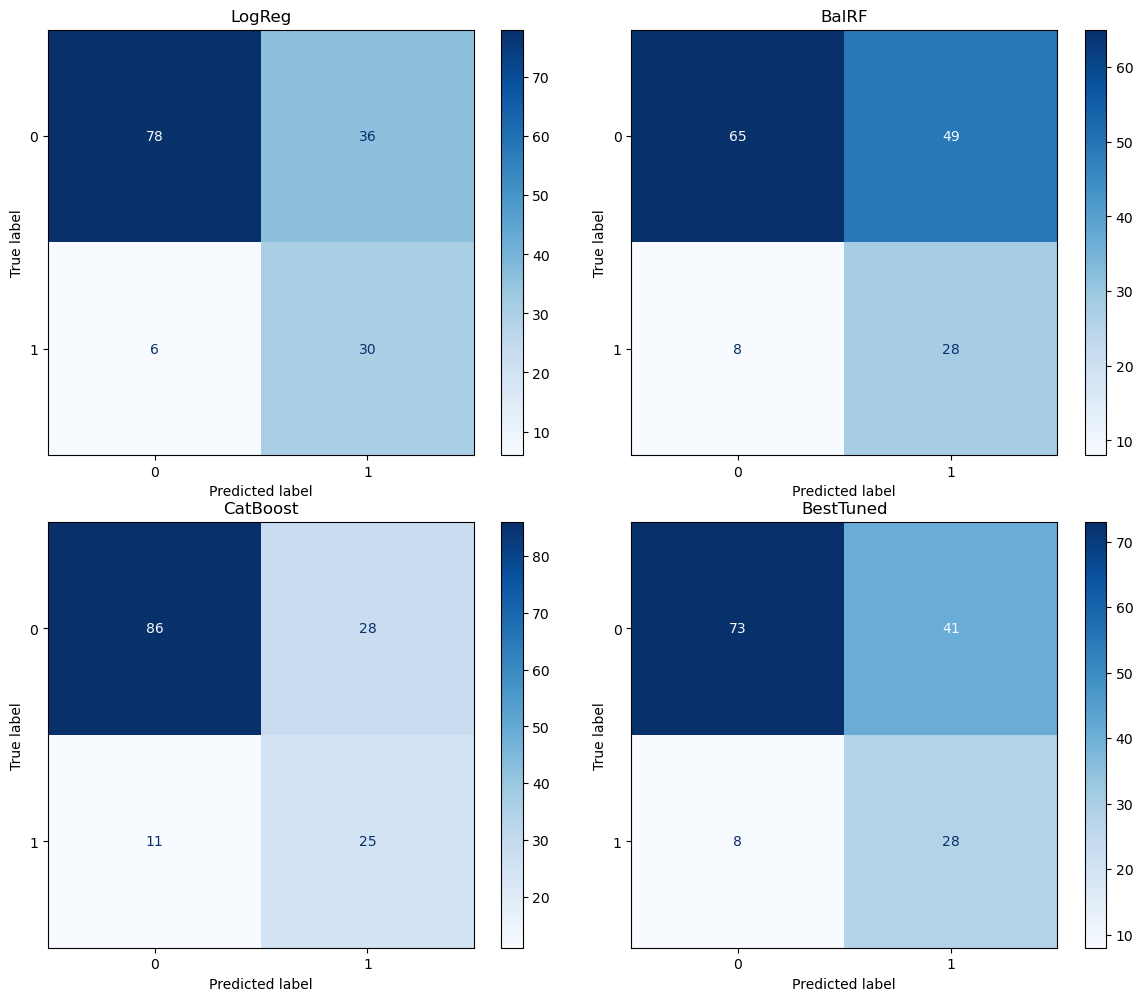

In [82]:
models = [
    ("LogReg",     blood_lr),
    ("BalRF",      pipe_brf),
    ("CatBoost",   pipe_cat),
    ("BestTuned",  best_model)
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.flat, models):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[0, 1]
    )
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(name)

plt.tight_layout()
plt.show()


Найкращий баланс між Recall і Precision та найвищий макро-F1 показує CatBoost (його TN і TP найвищі й найзбалансованіші).

LogReg цілком добре знаходить позитивні приклади (Recall_1 високий), але генерує багато хибнопозитивних спрацювань.

BalancedRF виявилася найменш ефективною за обома класами.

BestTuned підвищила Recall_1 порівняно з CatBoost, але це відбулося за рахунок зниження Recall_0.

Якщо задача рівномірно «ловити» обидва класи, краще CatBoost. Якщо ж критично не пропускати позитивні випадки (мінімізувати FN), варто зупинитися на BestTuned (Recall_1 = 0.75 при меншій кількості FP, ніж у LogReg).


ROC-крива показує, як змінюється чутливість моделі) при різних рівнях похибкових спрацьовувань. Площа під цією кривою (AUC) дає узагальнену оцінку її здатності відрізняти позитивні та негативні приклади - чим ближче AUC до 1, тим краща модель.

Побудувємо ROC-криві для всіх моделей на тестовому наборі:

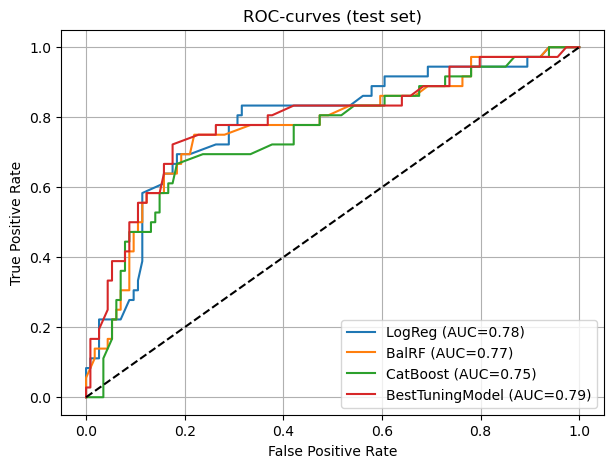

In [86]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7,5))

for name, pipe in [("LogReg", blood_lr),
                   ("BalRF", pipe_brf),
                   ("CatBoost", pipe_cat),
                  ("BestTuningModel", best_model),]:
    y_prob = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.title("ROC-curves (test set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(); plt.show()


Сумісний аналіз ROC-кривих і матриць невідповідностей показує, що:

BalancedRF стабільно відстає за всіма критеріями: найнижчий AUC (0.77), найгірший баланс TN/TP і відповідно низькі Recall/Precision для обох класів.

LogReg (як базова логістична регресія) і BestTuned (оптимізована версія логістичної регресії) демонструють найвищу дискримінаційну здатність (AUC =0.78). При цьому BestTuned трохи покращила Recall для рідкого класу 1 у порівнянні з LogReg.

CatBoost має найкращу збалансованість у матрицях невідповідностей (найвищі TN і TP серед усіх) і відповідає високому макро-F1 (0.69), хоч його AUC трохи нижче (0.75).

**Загальний висновок:**

Якщо пріоритет - «відсічення» обох класів із високою макро-F1 та збалансованим розподілом помилок, CatBoost є найнадійнішим вибором.

Якщо важлива максимальна дискримінація незалежно від порогу (найбільший AUC), або потрібно збільшити Recall для позитивного класу без суттєвого падіння AUC, варто розглянути логістичну регресію з тонким підбором (BestTuned).